In [27]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


In [43]:
# Read Taiwan export data
export = pd.read_csv('../data/processed/export_tw.csv')

export['Period'].unique() # No record in 1996

array([1998, 1997, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003, 2002,
       2001, 2000, 1999, 2011, 2012, 2013, 2021, 2020, 2019, 2018, 2017,
       2016, 2015, 2014])

In [44]:
# Read gravity data invovling Taiwan
gravity_tw = pd.read_csv('../data/processed/gravity_tw.csv')

gravity_tw['year'].unique()


array([1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019, 2020, 2021])

In [45]:
# Read political index
pv_all = pd.read_excel('../data/raw/wgidataset.xlsx',sheet_name='Political StabilityNoViolence', skiprows=14)

# Transform the data from wide to long
pv_all = pv_all.melt(id_vars=['Code','Country/Territory'], var_name='Year', value_name='pv')
pv_all.to_csv('../data/processed/pv_index.csv')


In [46]:
# Select political index related to Taiwan, and keep columns only 'Year' and 'pv'
pv_index_taiwan = pv_all[pv_all['Code']=='TWN'][['Year','pv']]
pv_index_taiwan

,Year,pv
194,1996,1.056969
408,1998,0.957363
622,2000,0.537107
836,2002,0.698526
1050,2003,0.637641
1264,2004,0.612769
1478,2005,0.671793
1692,2006,0.675702
1906,2007,0.552530
2120,2008,0.841073


In [47]:
pv_index_taiwan['Year'].unique()  # No records in 1997, 1999, 2001

array([1996, 1998, 2000, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021], dtype=object)

In [48]:
# Merge Taiwan political index with Global political index
pv_index = pd.merge(pv_all,pv_index_taiwan, on='Year',how='left')

# Rename columns
pv_index.rename(columns={'pv_x': 'pv_d','pv_y':'pv_o'}, inplace=True)

pv_index

,Code,Country/Territory,Year,pv_d,pv_o
0,ABW,Aruba,1996,NaN,1.056969
1,ADO,Andorra,1996,1.169522,1.056969
2,AFG,Afghanistan,1996,-2.417310,1.056969
3,AGO,Angola,1996,-2.061917,1.056969
4,AIA,Anguilla,1996,NaN,1.056969
...,...,...,...,...,...
4917,SRB,Serbia,2021,-0.134226,0.780216
4918,ZAF,South Africa,2021,-0.706577,0.780216
4919,ZAR,"Congo, Dem. Rep.",2021,-1.614667,0.780216
4920,ZMB,Zambia,2021,0.060216,0.780216


In [49]:
# Merge political index with Taiwan export data
data = pd.merge(export, pv_index, left_on=['Period','PartnerISO'], right_on=['Year','Code'], how='left')

# Keep columns
data = data[['Year','PartnerISO','PartnerDesc','PrimaryValue','pv_o','pv_d']]

# Drop records containing Nan
data = data.dropna()

# Construct the data for modelling by merging
model_data = pd.merge(data,gravity_tw,left_on=['Year','PartnerISO'], right_on=['year','iso3_d'], how='left')
model_data = model_data[['Year','iso3_d','PartnerDesc','PrimaryValue','pv_o','pv_d','dist','gdp_ppp_d','gdp_source_o', 'gdp_source_d','fta_wto']]
model_data = model_data.dropna()

# Save to csv file
model_data.to_csv('../data/processed/model_data.csv',index=False)

In [50]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1987 entries, 0 to 2805
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          1987 non-null   object 
 1   iso3_d        1987 non-null   object 
 2   PartnerDesc   1987 non-null   object 
 3   PrimaryValue  1987 non-null   float64
 4   pv_o          1987 non-null   float64
 5   pv_d          1987 non-null   float64
 6   dist          1987 non-null   float64
 7   gdp_ppp_d     1987 non-null   float64
 8   gdp_source_o  1987 non-null   float64
 9   gdp_source_d  1987 non-null   float64
 10  fta_wto       1987 non-null   float64
dtypes: float64(8), object(3)
memory usage: 186.3+ KB


In [51]:
# Get unique values and their counts from the 'column_name' column
value_counts = model_data['Year'].value_counts()

print(value_counts)

Year
2006    133
2011    127
2012    127
2008    126
2007    126
2005    125
2013    123
2014    118
2015    118
2004    117
2010    116
2016    112
2009    111
2003    108
2000    107
2002    106
1998     87
Name: count, dtype: int64


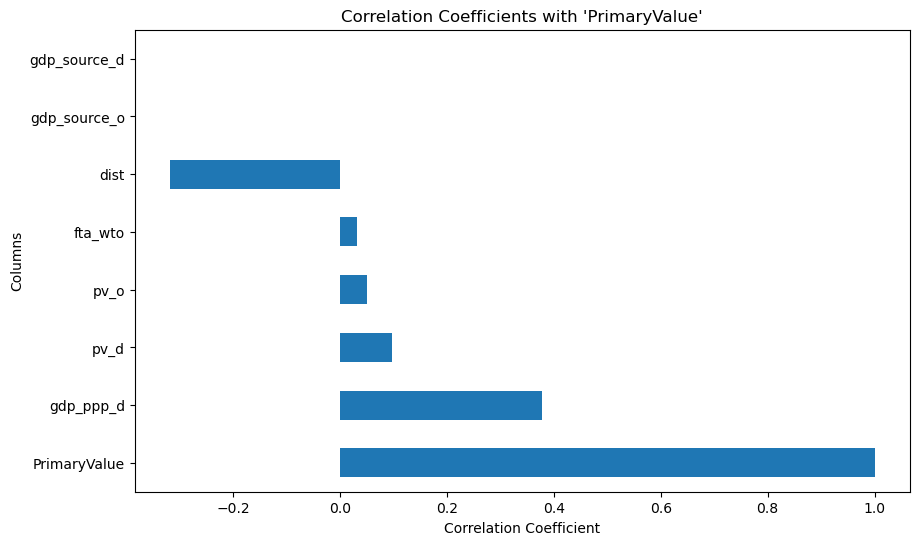

In [52]:
# Check correlation
num_cols = list(model_data.select_dtypes(include=['number']).columns)
correlation_data = model_data[num_cols].corr().loc["PrimaryValue"].sort_values(ascending=False)

# Top 10 positive linearly correlated columns with Laf25
plt.figure(figsize=(10, 6))
correlation_data.head(10).plot(kind="barh")
plt.ylabel("Columns")
plt.xlabel("Correlation Coefficient")
plt.title("Correlation Coefficients with 'PrimaryValue'")
plt.show()

In [53]:
# Drop columns
model_data = model_data.drop(['gdp_source_o','gdp_source_d'], axis=1)

In [54]:
# Drop columns
model_data = model_data.drop(['iso3_d','PartnerDesc','Year'], axis=1)

# Standardize the data
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on your feature data
scaled_features = scaler.fit_transform(model_data)

# Create a new DataFrame with standardized features
model_data = pd.DataFrame(scaled_features, columns=model_data.columns)

In [55]:
# Create features X and target y
X = model_data.drop(['PrimaryValue'], axis=1)
y = model_data['PrimaryValue']

# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize model
models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(random_state=42)]

# Loop training and predict
for model in models:
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f'Model Performance: {model.__class__.__name__}, Mean Squared Error: {mse}, R-squared: {r2}')

Model Performance: LinearRegression, Mean Squared Error: 0.8587408716261956, R-squared: 0.19817933195863013
Model Performance: DecisionTreeRegressor, Mean Squared Error: 0.35201271781432564, R-squared: 0.6713198569174393
Model Performance: RandomForestRegressor, Mean Squared Error: 0.041848317848095264, R-squared: 0.9609255279653517


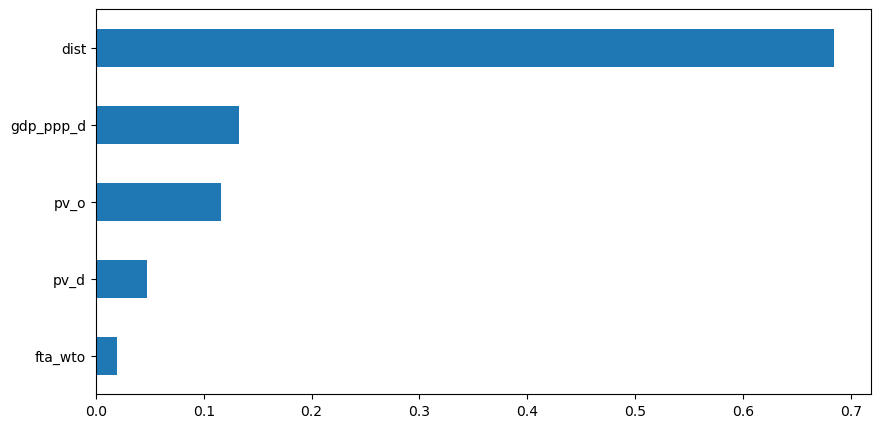

In [56]:
# Model interpretation
model_final = RandomForestRegressor(random_state=42)
model_final.fit(X, y)

feature_importance = model_final.feature_importances_
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, feature_importance))
feature_importance_s = pd.Series(feature_importance_dict).sort_values()

fig, ax = plt.subplots(figsize=(10, 5))
feature_importance_s.plot(kind='barh', ax=ax)
ax.tick_params(axis='y', labelsize=10)

In [57]:
feature_importance_s

fta_wto      0.019289
pv_d         0.047428
pv_o         0.115933
gdp_ppp_d    0.132973
dist         0.684376
dtype: float64